# LIME-Aleph

Willkommen zum Beispiel für das Modul __LIME-Aleph__ im KI-Campus. Hier werden Sie den typischen Ablauf zum Finden einer symbolischen Erklärung für Black-Box Netzwerke mithilfe der LIME-Aleph Bibliothek beschreiben.

__Hinweis__: Bitte setzen Sie das Notebook zurück wenn sie dieses ein zweites mal ausführen möchten. 
    Im Menü über __(Kernel > Restart)__.

Zunächst importieren wir die benötigten Bibliotheken und definieren einige Parameter. 
Im Beispiel nutzen wir ein Bild zur Klassifikation und ein bereits bestehendes und vortrainiertes Modell. 

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from skimage.util import img_as_float32
from skimage.transform import resize
from scripts.train_model import own_rel
from skimage import io
from skimage.io import imshow, show, imsave
import shutil
from graphviz import Digraph

import lime_aleph.lime_aleph as la

IMAGE_FILE = os.path.abspath("pos9000.png") # The path to the image file to be classified by the black-box
MODEL = "../models_to_explain/model_tower.h5" # The path to the pre-trained model
N = 1000 # The sample size for LIME
OUTPUT_DIR = os.path.abspath("../output/") + "/" # A path for a directory to save intermediate and output data
T = 0.8 # The threshold for the binary classifier for when an example is classified as 'positive'
NOISE = 10 # The allowed false-positive rate for Aleph in percent.b

Sollte es noch temporäre Daten aus früheren Durchläufen geben, sollen diese nun gelöscht werden:

In [2]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR)

Wir laden das Bild und das vortrainierte Modell in den Speicher. 

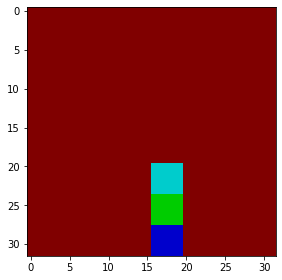

In [3]:
image = img_as_float32(io.imread(IMAGE_FILE))
image = resize(image, (own_rel.IMAGE_SIZE, own_rel.IMAGE_SIZE), anti_aliasing=True)

model = own_rel.own_rel()
model.load_weights(MODEL)

io.imshow(image)
io.show()

## Annotation des Bildes
Im Folgenden werden die im Bild vorhandenen Elemente automatisch annotiert. 
Dazu verwenden wir die Funktion __annotate_image_parts__ aus dem Package __lime_aleph__.

In [4]:
annotated_image = la.annotate_image_parts(image, model, OUTPUT_DIR, N)

Running LIME...
True class of the image is:  1
Starting the explanation generation process. This may take a while.


/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


  0%|          | 0/1000 [00:00<?, ?it/s]

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Intercept -0.17073857787998975
Prediction_local [0.28741663]
Right: 0.023822423
Intercept 1.1707385929629113
Prediction_local [0.71258336]
Right: 0.9761776
Number of superpixels: 64
Annotating the superpixels...
Weight of sp:  44 is:  0.12913387229572454
Weight of sp:  60 is:  0.10259986705131253
Weight of sp:  52 is:  0.09230449023658491
Weight of sp:  46 is:  -0.05201422798565976
Weight of sp:  17 is:  -0.045131582930978735
Weight of sp:  26 is:  -0.03427814669335754
Weight of sp:  40 is:  -0.03177134333767318
Weight of sp:  31 is:  -0.031290270620267784
Weight of sp:  50 is:  -0.029796583217054327
Weight of sp:  53 is:  -0.0292943849212643
Weight of sp:  45 is:  -0.02926745361912772
Weight of sp:  34 is:  -0.028584243233480185
Weight of sp:  22 is:  -0.028553532401583415
Weight of sp:  24 is:  -0.02552568372141612
Weight of sp:  15 is:  -0.025000771031626633
Weight of sp:  57 is:  -0.024608546977781746
Weight of sp:  36 is:  -0.023670061199463598
Weight of sp:  2 is:  -0.02276754495

Die Funktion findet auch die Bildteile, die laut LIME für die Klasse am wichtigsten sind. Wir können diese Teile sowohl für die positive als auch für die negative Klasse visualisieren.
Das erste Bild zeigt die wichtigsten drei Features im Bild für die Klasse __Turm__, hier werden die drei Bauklötze erkannt.  

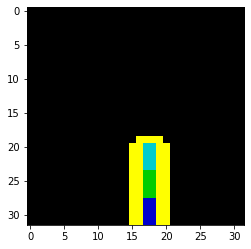

In [7]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

true_class = 1

temp, mask = annotated_image.explanation.get_image_and_mask(true_class, positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Das zweite Bild zeigt dazu konträr zur Klasse Turm drei Features, d.h. es werden drei Bereiche der Hintergrundfarbe identifiziert, die voneinander entfernt sind und nicht alle einander berühren wie die Bauklötze des Turms.

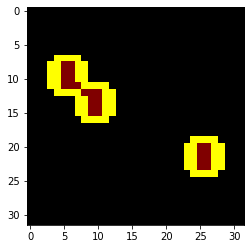

In [8]:
negative_class = 0

temp, mask = annotated_image.explanation.get_image_and_mask(negative_class, positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Nachdem das Bild nun annotiert ist, können wir nun die wichtigsten __3__ Bildelemente mit der Funktion __find_important_parts__ finden. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


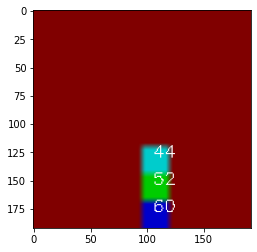

In [12]:
important_superpixels, labeled_image = la.find_important_parts(annotated_image, 3) 

plt.imshow(labeled_image)

Im Bild werden den Bereichen Zahlen d.h. Klassenidentifier zugeordnet. 
Anschließend können wir die Relationen zwischen diesen Bildteilen mit der Funktion __find_spatial_relations__ identifizieren und als Graph extrahieren. 
Dies geschieht über die Funktion __find_spatial_relations__, angewendet auf die wichtigen Superpixel (Objekt __important_superpixels__). 

In [13]:
relations, graph = la.find_spatial_relations(important_superpixels)

Den Graph können wir nun mittels Graphviz visualisieren. 
Dieser beschreibt anhand binärer Relationen die topologischen Abhängigkeiten zwischen den einzelnen Objektklassen.
Die Kanten und deren Label repräsentieren die räumlichen Relationen. 

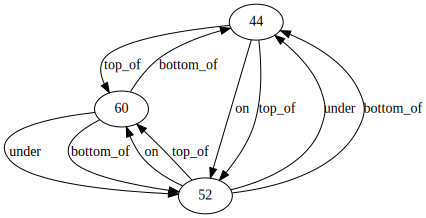

In [14]:
graph

Diese Relationen können wir auch textuell ausgeben lassen: 

In [15]:
for rel in relations:
    print(rel)

Relation: 60 -- bottom_of --> 44
Relation: 52 -- under --> 44
Relation: 52 -- bottom_of --> 44
Relation: 44 -- top_of --> 60
Relation: 52 -- on --> 60
Relation: 52 -- top_of --> 60
Relation: 44 -- on --> 52
Relation: 44 -- top_of --> 52
Relation: 60 -- under --> 52
Relation: 60 -- bottom_of --> 52


## Erzeugung perturbierter Instanzen
Nun lassen wir uns das perturbierte Datenset für LIME-Aleph generieren. Hierzu nutzen wir die Funktion __perturb_instance__ mit den erforderlichen Parametern. Dabei geben wir im Anschluss auch aus, wie viele Instanzen im neuen Datenset enthalten sind (Liste der Instanzen).

In [16]:
perturbed_dataset = la.perturb_instance(annotated_image, relations, model, T)
print("Number of perturbed instances:", len(perturbed_dataset))

/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Number of perturbed instances: 11


Diese Instanzen können wir inspizieren und sehen dabei, dass positive und negative Beispiele generiert werden.

In [17]:
for ex in perturbed_dataset:
    print(ex)
    print("-------------------------------")

Example: Positive: True,
Superpixels:
60, 44,
52,

Relations:
Relation: 60 -- bottom_of --> 44
, Relation: 52 -- under --> 44
, Relation: 52 -- bottom_of --> 44
, Relation: 44 -- top_of --> 60
, Relation: 52 -- on --> 60
, Relation: 52 -- top_of --> 60
, Relation: 44 -- on --> 52
, Relation: 44 -- top_of --> 52
, Relation: 60 -- under --> 52
, Relation: 60 -- bottom_of --> 52

-------------------------------
Example: Positive: False,
Superpixels:
60, 44,
52,

Relations:
Relation: 44 -- bottom_of --> 60
, Relation: 52 -- under --> 60
, Relation: 52 -- bottom_of --> 60
, Relation: 60 -- top_of --> 44
, Relation: 52 -- on --> 44
, Relation: 52 -- top_of --> 44
, Relation: 60 -- on --> 52
, Relation: 60 -- top_of --> 52
, Relation: 44 -- under --> 52
, Relation: 44 -- bottom_of --> 52

-------------------------------
Example: Positive: True,
Superpixels:
60, 44,
52,

Relations:
Relation: 60 -- bottom_of --> 52
, Relation: 44 -- under --> 52
, Relation: 44 -- bottom_of --> 52
, Relation: 52

Jetzt visualisieren wir exemplarisch je eine Instanz der positiven und der negativen Klasse für Turm.

In [18]:
vars(perturbed_dataset[3])

{'superpixels': [60, 44, 52],
 'positive': True,
 'relations': [<lime_aleph.lime_aleph.Relation at 0x19b1a5af0>,
  <lime_aleph.lime_aleph.Relation at 0x19b18fe20>]}

In [ ]:
spxls, positive, relations = (name for name in ('bob','fred') if name=='bob')

Das ILP-Framework Aleph benötigt mehrere Hilfsdateien, die mit der Funktion __write_aleph_files__ erzeugt werden. 
Es sollen alle räumlichen Relationen verwendet werden! Zur Verfügung stehen folgende Relationen: *left_of*, *right_of*, *top_of*, *bottom_of*, *on*, *under*

In [20]:
used_relations = None # 'None' if you want to allow all relations, otherwise list with following possibilities: ["left_of", "right_of", "top_of", "bottom_of", "on", "under"]
la.write_aleph_files(annotated_image, perturbed_dataset, used_relations, OUTPUT_DIR, NOISE)

Writing the input files for Aleph...
/Users/sees/Documents/IIS/Code/LIME-Aleph/output/
Done.


Schlussendlich muss nun der Induktionsprozess von Aleph angestoßen werden. Dieser Schritt (mit der Funktion __run_aleph__) gibt auch die gefundene Erklärung zurück:

In [21]:
la.run_aleph(OUTPUT_DIR)

[{}]
[{}]
[{}]
[{}]
[{}]
The explanation was saved to '/Users/sees/Documents/IIS/Code/LIME-Aleph/output/explanation.txt'


Die Erklärung in Form von Regeln kann findet sich nun im angegebenen Ordner in der Datei *explanation.txt*. 
Wir lesen diese Datei aus und stellen die Regel in Form einer Prolog-Regel dar.

In [22]:
with open(OUTPUT_DIR + "explanation.txt", 'r') as f:
    print(f.read())

true_class(A) :-
   contains(B,A), contains(C,A), has_color(C,lime), on_in_ex(C,B,A).



## Interpretation
Die Interpretation der Regel wollen wir im Folgenden an einem Beispiel darstellen. 

true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).

Die Lesart der Regel ist wie folgt. Das Prädikat __true_class(A)__ entspricht der Aussage _"A ist ein Turm"_ und gilt wenn folgende Aussagen logisch wahr sind:
* der Turm A enthällt einen Bauklotz B, 
* Bauklotz B hat die Farbe Blau (__mediumblue__),
* der Turm A enthält auch einen Bauklotz C,
* der Bauklotz C hat die Farbe Grün (__lime__), und 
* C befindet sich in Relation __top_of__ zu B, d.h. C steht räumlich auf B.
